# Imports

In [23]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract
import Levenshtein as lv


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append(r"C:\Users\sondors\Documents\TensorFlow\models\research")
sys.path.append(r"C:\Users\sondors\Documents\TensorFlow\models\research\object_detection")
sys.path.append(r"C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\ssd_mobilenet_v1_coco\saved_model")
from object_detection.utils import ops as utils_ops

'''if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')'''


"if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):\n  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')"

## Env setup

In [24]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [25]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [26]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\ssd_mobilenet_v1_coco\saved_model\frozen_inference_graph2.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\ssd_mobilenet_v1_coco\saved_model\object-detection.pbtxt'

## Load a (frozen) Tensorflow model into memory.

In [27]:
sys.path.append(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\ssd_mobilenet_v1_coco\saved_model\graph.pbtxt')
PATH_TO_FROZEN_GRAPH = r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\ssd_mobilenet_v1_coco\saved_model\frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [28]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [29]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [30]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (24, 18)

In [31]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

"print(len(Xmin1), len(Xmin2))\nprint('Xmin1,2:', (Xmin1), (Xmin2)) \nprint('Xmax1,2:', (Xmax1), (Xmax2)) \nprint('Xmin1,2:', (Ymin1), (Ymin2)) \nprint('Xmax1,2:', (Ymax1), (Ymax2))\nprint()\n#print(len(Xmin))\nprint('Xmin:', (Xmin)) \nprint('Xmax:', (Xmax)) \nprint('Ymin:', (Ymin)) \nprint('Ymax:', (Ymax))"

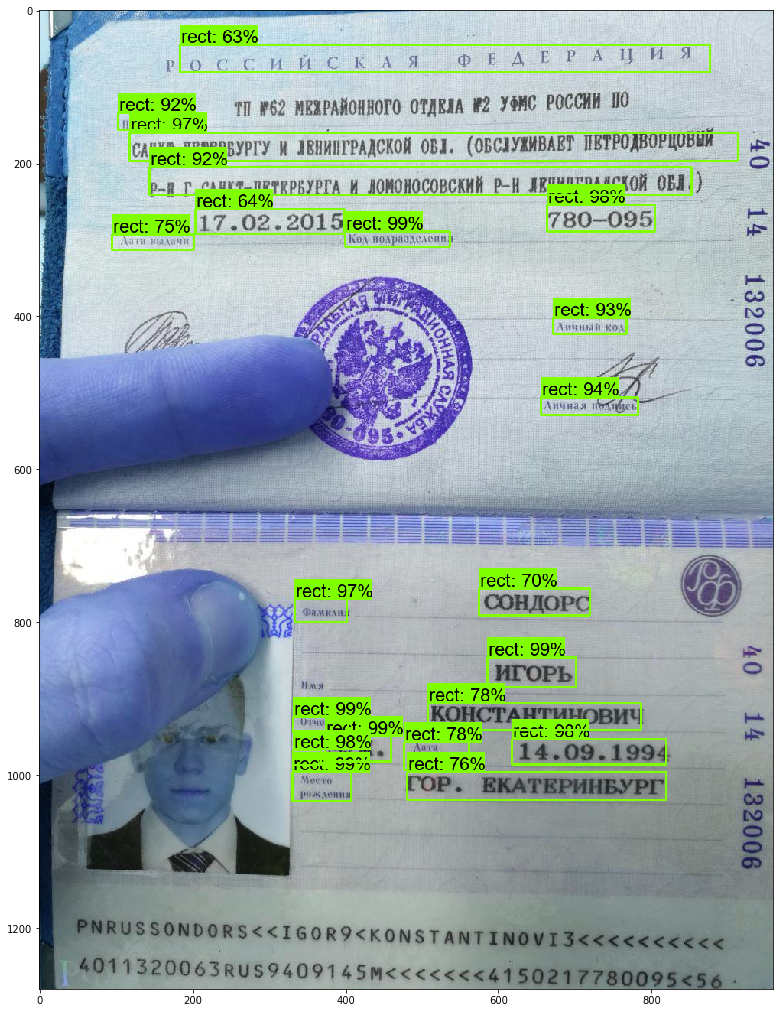

In [32]:
for image_path in TEST_IMAGE_PATHS:
  image = cv2.imread(image_path)


  #Режем image на две части, тк модель принимает изображения 300на300
    
    
  H, W = np.shape(image)[:2]

  image1 = image.copy()[0:int(1*H/2), :, :]
  image2 = image.copy()[int(1*H/2):int(H), :, :]
  

  #Запускаем модель для первой половины image


  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np1 = image1
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded1 = np.expand_dims(image_np1, axis=0)
  


    
    
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np1, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np1,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)
    
    
    
    
      # Ниже извлекаем координаты ректанглов  
  Xmax1 =[]
  Xmin1 =[]
  Ymax1 =[]
  Ymin1 =[]    
  for i, box in enumerate(output_dict['detection_boxes']):
    if output_dict['detection_scores'][i] > 0.30:
        

    
        h, w = np.shape(image1)[:2]
        
       
        y1 = int(box[0]*h)
        x1 = int(box[1]*w)
        y2 = int(box[2]*h)
        x2 = int(box[3]*w)
        
        #Добавляем padding
        deltaX = 0.05
        deltaY = 0.15
        
        y1new = round(int(y1 - (y2 - y1)*deltaY))
        x1new = round(int(x1 - (x2 - x1)*deltaX))
        y2new = round(int(y2 + (y2 - y1)*deltaY))
        x2new = round(int(x2 + (x2 - x1)*deltaX))
        
        Xmax1.append(x2new)
        Xmin1.append(x1new)
        Ymax1.append(y2new)
        Ymin1.append(y1new)


    
  #Повторяем для второй половины image  

    
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np2 = image2
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded2 = np.expand_dims(image_np2, axis=0)

    
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np2, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np2,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)    
    
  #Извлечение координат производим по двум половинам по-отдельности, кроп по  оригиналу, к игрековым координатам второй половины добавляем половину игрек шейпа
  Xmax2 =[]
  Xmin2 =[]
  Ymax2 =[]
  Ymin2 =[]    
  for i, box in enumerate(output_dict['detection_boxes']):
    if output_dict['detection_scores'][i] > 0.30:
        

    
        h, w = np.shape(image2)[:2]
        
       
        y1 = int(box[0]*h) + int(np.shape(image)[0]/2)
        x1 = int(box[1]*w)
        y2 = int(box[2]*h) + int(np.shape(image)[0]/2)
        x2 = int(box[3]*w)
        
        #Добавляем padding
        deltaX = 0.05
        deltaY = 0.15
        
        y1new = round(int(y1 - (y2 - y1)*deltaY))
        x1new = round(int(x1 - (x2 - x1)*deltaX))
        y2new = round(int(y2 + (y2 - y1)*deltaY))
        x2new = round(int(x2 + (x2 - x1)*deltaX))
        
        Xmax2.append(x2new)
        Xmin2.append(x1new)
        Ymax2.append(y2new)
        Ymin2.append(y1new)

  Xmin = np.concatenate((Xmin1, Xmin2), axis=0)      
  Xmax = np.concatenate((Xmax1, Xmax2), axis=0)
  Ymin = np.concatenate((Ymin1, Ymin2), axis=0)      
  Ymax = np.concatenate((Ymax1, Ymax2), axis=0)
    
 #Склеиваем img1 и img2, рисуем их  
    
  img_res = np.concatenate((image1, image2), axis=0)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(img_res)
    
  cv2.imwrite(r'C:\Users\sondors\Desktop\OpenCV\111.jpg', img_res) 





'''print(len(Xmin1), len(Xmin2))
print('Xmin1,2:', (Xmin1), (Xmin2)) 
print('Xmax1,2:', (Xmax1), (Xmax2)) 
print('Xmin1,2:', (Ymin1), (Ymin2)) 
print('Xmax1,2:', (Ymax1), (Ymax2))
print()
#print(len(Xmin))
print('Xmin:', (Xmin)) 
print('Xmax:', (Xmax)) 
print('Ymin:', (Ymin)) 
print('Ymax:', (Ymax))'''


In [33]:
#Сортировка ректанглов

res = []
for i in range(len(Xmin)):
    if i<=len(Xmin):
        res.append([Xmin[i], Ymin[i], Xmax[i], Ymax[i]])        

res = sorted(res, key=lambda r:r[3])
print(res)


[[149, 39, 911, 86], [236, 98, 825, 146], [97, 130, 220, 159], [78, 154, 953, 202], [108, 199, 888, 246], [656, 248, 812, 294], [194, 255, 408, 296], [393, 286, 543, 312], [89, 290, 207, 316], [667, 398, 772, 426], [649, 502, 789, 532], [567, 750, 727, 796], [330, 765, 405, 804], [580, 840, 707, 890], [331, 867, 377, 897], [494, 900, 800, 946], [328, 921, 407, 947], [369, 944, 464, 986], [607, 948, 830, 990], [330, 964, 369, 990], [472, 951, 566, 998], [464, 990, 836, 1037], [327, 990, 411, 1039]]


In [34]:
heigh = []
width = []

for i in range(len(res)):
    width.append(res[i][2] - res[i][0])
    heigh.append(res[i][3] - res[i][1])
print('width:', width)
print(len(width))

print('heigh:', heigh)
print(len(heigh))

crops = []

for i in range(len(res)):
    crops.append([width[i], heigh[i]])
    
print('crops:', crops)
print(len(crops))

relatives = []
for i in range(len(res)):
    relatives.append(round(crops[i][0]/crops[i][1]))
    
    
print('relatives:', relatives)
print(len(relatives))

    

width: [762, 589, 123, 875, 780, 156, 214, 150, 118, 105, 140, 160, 75, 127, 46, 306, 79, 95, 223, 39, 94, 372, 84]
23
heigh: [47, 48, 29, 48, 47, 46, 41, 26, 26, 28, 30, 46, 39, 50, 30, 46, 26, 42, 42, 26, 47, 47, 49]
23
crops: [[762, 47], [589, 48], [123, 29], [875, 48], [780, 47], [156, 46], [214, 41], [150, 26], [118, 26], [105, 28], [140, 30], [160, 46], [75, 39], [127, 50], [46, 30], [306, 46], [79, 26], [95, 42], [223, 42], [39, 26], [94, 47], [372, 47], [84, 49]]
23
relatives: [16.0, 12.0, 4.0, 18.0, 17.0, 3.0, 5.0, 6.0, 5.0, 4.0, 5.0, 3.0, 2.0, 3.0, 2.0, 7.0, 3.0, 2.0, 5.0, 2.0, 2.0, 8.0, 2.0]
23


In [35]:
H = []
W = []
for i in range(len(res)):
    w = res[i][2] - res[i][0]
    W.append(w)
    h = res[i][3] - res[i][1]
    H.append(h)
print(W)
print(H)
print(len(W), len(H))

for i in range(len(res)):
    pts1 = np.float32([[res[i][0], res[i][1]], [res[i][2], res[i][1]], [res[i][2], res[i][3]], [res[i][0], res[i][3]]])
    pts2 = np.float32([[0,0],[W[i],0],[W[i],H[i]],[0,H[i]]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    img = cv2.imread(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images\1.jpg',3)
    
    
    #Попытка сделать нормальный постпроцессинг
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    '''gray = cv2.medianBlur(gray, 3)
    gray = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]'''

    dst = cv2.warpPerspective(gray,M,(W[i], H[i]))
    
    #Попробуем ресайз
    #dst = cv2.resize(dst, (0,0), fx=2, fy=2)
    
    
    cv2.imwrite(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images\crop\{}.jpg'.format(i), dst)

[762, 589, 123, 875, 780, 156, 214, 150, 118, 105, 140, 160, 75, 127, 46, 306, 79, 95, 223, 39, 94, 372, 84]
[47, 48, 29, 48, 47, 46, 41, 26, 26, 28, 30, 46, 39, 50, 30, 46, 26, 42, 42, 26, 47, 47, 49]
23 23


In [36]:
#Пробуем постпроцессинг методом бинаризации Саувола и Ниблака
######################################################################################
'''from skimage.filters import (threshold_otsu, threshold_niblack,
                         threshold_sauvola)
image = dst
window_size = 25
thresh_sauvola = threshold_sauvola(image, window_size=window_size)
binary_sauvola = image > thresh_sauvola

thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
binary_niblack = image > thresh_niblack


dpi = 300.0 
w, h = binary_sauvola.shape[1]/dpi, binary_sauvola.shape[0]/dpi 
fig = plt.figure(figsize=(w,h), dpi=dpi) 
fig.figimage(binary_sauvola, cmap=plt.cm.gray)
plt.savefig(r'C:\\Users\\sondors\\Documents\\TensorFlow\\models\\research\\object_detection\\test_images\\crop\{}.jpg'.format(i))'''
##################################################################################

"from skimage.filters import (threshold_otsu, threshold_niblack,\n                         threshold_sauvola)\nimage = dst\nwindow_size = 25\nthresh_sauvola = threshold_sauvola(image, window_size=window_size)\nbinary_sauvola = image > thresh_sauvola\n\nthresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)\nbinary_niblack = image > thresh_niblack\n\n\ndpi = 300.0 \nw, h = binary_sauvola.shape[1]/dpi, binary_sauvola.shape[0]/dpi \nfig = plt.figure(figsize=(w,h), dpi=dpi) \nfig.figimage(binary_sauvola, cmap=plt.cm.gray)\nplt.savefig(r'C:\\Users\\sondors\\Documents\\TensorFlow\\models\\research\\object_detection\\test_images\\crop\\{}.jpg'.format(i))"

In [37]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Users\\sondors\\AppData\\Local\\Tesseract-OCR\\tesseract'
sys.path.append(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images\crop')
config = ("-l rus --oem 1 --psm 7")
text = []
for i in range(len(res)):
    print(pytesseract.image_to_string(Image.open(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images\crop\{}.jpg'.format(i)), config = config))
    

россии скАая ФЕАЛЕРАНИЯ
ЧП #62 МЕЖРАЙОННОГО ОТДЕЛА №2 УФИС РОССИИ ПО
Паспорт вылан.
САНКТ-ПЕТЕРБУРГУ й ЛЕНИНГРАДСКОЙ ов1. (ОБСЛУЖИВАЕТ ПЕТРОДВОРЦОВЫЙ =
р-й Г. САНКТ-ПЕТЕРВУРГА И ЛОМОНОСОВСКИЙ Р-Н ЛЕНИЯГРАДСКОЙ овл.)
780-095
17.02.2015
Код нодразделения
ата вылачи
Личный код.
Аннная оХЯбеь>
СОНДОРС
, Фамилия
ИГОРЬ
Имя
КОНСТАНТИНОВИЧ
| ‘Отчество.
МУЖ.
14.09.1994
пох
ко
ГОР. ЕКАТЕРИНБУРГ
ры


In [38]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Users\\sondors\\AppData\\Local\\Tesseract-OCR\\tesseract'
sys.path.append(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images\crop')
config = ("-l rus --oem 1 --psm 7")
text = []
for i in range(len(res)):
    text.append(pytesseract.image_to_string(Image.open(r'C:\Users\sondors\Documents\TensorFlow\models\research\object_detection\test_images\crop\{}.jpg'.format(i)), config = config))
print(text, len(text))

['россии скАая ФЕАЛЕРАНИЯ', 'ЧП #62 МЕЖРАЙОННОГО ОТДЕЛА №2 УФИС РОССИИ ПО', 'Паспорт вылан.', 'САНКТ-ПЕТЕРБУРГУ й ЛЕНИНГРАДСКОЙ ов1. (ОБСЛУЖИВАЕТ ПЕТРОДВОРЦОВЫЙ =', 'р-й Г. САНКТ-ПЕТЕРВУРГА И ЛОМОНОСОВСКИЙ Р-Н ЛЕНИЯГРАДСКОЙ овл.)', '780-095', '17.02.2015', 'Код нодразделения', 'ата вылачи', 'Личный код.', 'Аннная оХЯбеь>', 'СОНДОРС', ', Фамилия', 'ИГОРЬ', 'Имя', 'КОНСТАНТИНОВИЧ', '| ‘Отчество.', 'МУЖ.', '14.09.1994', 'пох', 'ко', 'ГОР. ЕКАТЕРИНБУРГ', 'ры'] 23


In [39]:
print(text, len(text), type(text))

['россии скАая ФЕАЛЕРАНИЯ', 'ЧП #62 МЕЖРАЙОННОГО ОТДЕЛА №2 УФИС РОССИИ ПО', 'Паспорт вылан.', 'САНКТ-ПЕТЕРБУРГУ й ЛЕНИНГРАДСКОЙ ов1. (ОБСЛУЖИВАЕТ ПЕТРОДВОРЦОВЫЙ =', 'р-й Г. САНКТ-ПЕТЕРВУРГА И ЛОМОНОСОВСКИЙ Р-Н ЛЕНИЯГРАДСКОЙ овл.)', '780-095', '17.02.2015', 'Код нодразделения', 'ата вылачи', 'Личный код.', 'Аннная оХЯбеь>', 'СОНДОРС', ', Фамилия', 'ИГОРЬ', 'Имя', 'КОНСТАНТИНОВИЧ', '| ‘Отчество.', 'МУЖ.', '14.09.1994', 'пох', 'ко', 'ГОР. ЕКАТЕРИНБУРГ', 'ры'] 23 <class 'list'>


In [40]:
mask = ['РОССИЙСКАЯ ФЕДЕРАЦИЯ','Паспорт выдан','Дата выдачи','Код подразделения','Личный код','Личная подпись','Фамилия','Имя','Отчество','Пол']
two_strings_mask = ['Дата рождения','Место рождения']


In [41]:
text1 = text
#text = ['россии скАЯ орла цИиЯя', 'ЧП #62 МЕЖРАЙОННОГО ОТДЕЛА №2 УФИС РОССИЯ ПО', 'Паспорт ван', 'САНКТ-ЛЕТЕРВУРГУ И ЛЕНИНГРАДСКОЙ ов1. (ОБСЛУЖИВАЕТ ПЕТРОДВОРНОВЫЙ |', 'р-й Г. САНКТ-ПЕТЕРВУРГА И ЛОМОНОСОВСКИЙ Р-Н ЛЕНИНГРАДСКОЙ ов.)', '780—095', '7.0.2015', 'Кол подразделения.', 'Лата вылачи.', 'Личный Код.', 'Аинная фев', 'СОНДОРС', '| Фамилия', 'ИГОРЬ', 'Имя.', 'Отчество.', 'КОНСТАНТИНОВИЧ', 'МУЖ.', 'Пол', '14.09.1994', 'к', 'ГОР. ЕКАТЕРИНБУРГ', 'Е']


In [42]:
#Замена слов маски паспорта по наименьшему расстоянию Левенштейна
txt_store = []

for i in range(len(text)):
    txt_store.append(text[i])
print(txt_store)
    
for j in range(len(mask)):
    dist = []
    
    for i in range(len(text)):
        dist.append(lv.distance(text[i], mask[j]))
        
    min_dist = min(dist)
    min_dist_ind = dist.index(min_dist)
    
    #del  text[min_dist_ind]
    #text = text.insert(min_dist_ind, '###################################')
    print(min_dist_ind, text[min_dist_ind])
    #print(text)
    del  txt_store[min_dist_ind]
    txt_store.insert(min_dist_ind, mask[j])
        
        
    print('min_dist:' , min_dist)
    #print('min_dist_ind:', min_dist_ind, text[min_dist_ind], '-->', txt_store[min_dist_ind]) 
        
    print('dist между mask номер', j, 'и text:', dist, len(dist))  

print()
print(text, len(text))
print()
#print(text, len(text))
print()
print(txt_store, len(txt_store))




#Место рождения и Дата рождения плохо распознаются тессерактом - это является причиной ошибки т9
'''
for j in range(len(two_strings_mask)):
    dist = []
    two_line_text = text1[-4:]
    
    for i in range(len(two_line_text)):
        dist.append(lv.distance(two_line_text[i], two_strings_mask[j]))
        
        min_dist = min(dist)
        min_dist_ind = dist.index(min_dist)
        
    del  text1[min_dist_ind]
    text1.insert(min_dist_ind, mask[j])
    
    del  two_strings_mask[j]
    two_strings_mask.insert(j, '#####################################')
    '''
    
    

        

['россии скАая ФЕАЛЕРАНИЯ', 'ЧП #62 МЕЖРАЙОННОГО ОТДЕЛА №2 УФИС РОССИИ ПО', 'Паспорт вылан.', 'САНКТ-ПЕТЕРБУРГУ й ЛЕНИНГРАДСКОЙ ов1. (ОБСЛУЖИВАЕТ ПЕТРОДВОРЦОВЫЙ =', 'р-й Г. САНКТ-ПЕТЕРВУРГА И ЛОМОНОСОВСКИЙ Р-Н ЛЕНИЯГРАДСКОЙ овл.)', '780-095', '17.02.2015', 'Код нодразделения', 'ата вылачи', 'Личный код.', 'Аннная оХЯбеь>', 'СОНДОРС', ', Фамилия', 'ИГОРЬ', 'Имя', 'КОНСТАНТИНОВИЧ', '| ‘Отчество.', 'МУЖ.', '14.09.1994', 'пох', 'ко', 'ГОР. ЕКАТЕРИНБУРГ', 'ры']
0 россии скАая ФЕАЛЕРАНИЯ
min_dist: 14
dist между mask номер 0 и text: [14, 37, 19, 58, 53, 20, 20, 20, 19, 19, 19, 17, 18, 18, 19, 16, 20, 20, 20, 20, 20, 16, 20] 23
2 Паспорт вылан.
min_dist: 2
dist между mask номер 1 и text: [21, 42, 2, 64, 61, 13, 13, 14, 9, 11, 14, 13, 13, 13, 13, 14, 13, 13, 13, 11, 12, 17, 11] 23
8 ата вылачи
min_dist: 2
dist между mask номер 2 и text: [21, 42, 9, 64, 62, 11, 11, 14, 2, 11, 12, 11, 10, 11, 11, 14, 12, 11, 11, 11, 11, 16, 10] 23
7 Код нодразделения
min_dist: 1
dist между mask номер 3 и text: [2

"\nfor j in range(len(two_strings_mask)):\n    dist = []\n    two_line_text = text1[-4:]\n    \n    for i in range(len(two_line_text)):\n        dist.append(lv.distance(two_line_text[i], two_strings_mask[j]))\n        \n        min_dist = min(dist)\n        min_dist_ind = dist.index(min_dist)\n        \n    del  text1[min_dist_ind]\n    text1.insert(min_dist_ind, mask[j])\n    \n    del  two_strings_mask[j]\n    two_strings_mask.insert(j, '#####################################')\n    "

In [43]:
import Levenshtein as lv
print(lv.distance('россии скАЯ орла цИиЯя' , 'РОССИЙСКАЯ ФЕДЕРАЦИЯ'))
print(lv.distance("Личная ныубеь”" , 'Личная подпись'))

18
7


In [44]:
#Удаляем страну выдачи паспорта, если она задетектирована
Country = ['РОССИЙСКАЯ ФЕДЕРАЦИЯ']
text1.remove('РОССИЙСКАЯ ФЕДЕРАЦИЯ')
print(text1)

ValueError: list.remove(x): x not in list

In [ ]:
#Получаем из распознанного текста личный код, дату выдачи паспорта и дату рождения человека в виде списка Dates
Dates = []
TenLength = []
digits = ''
dig = []

for i in range(len(text)):
    if len(text[i])==10:
        TenLength.append(text[i])
    if len(text[i])==7:
        TenLength.append(text[i])
        
for j in range(len(TenLength)):        
    dig.append(digits.join(i for i in TenLength[j] if i.isdigit()))
    
for i in range(len(dig)):
    if len(dig[i]) >= 6:
        Dates.append(TenLength[i])
        
#print(TenLength)
#print(dig)
print('Все числа:', Dates)

#Получаем из распознанного текста личный код человека по паспорту
PersonalCode = []
minLen = []
for i in range(len(Dates)):
    for i in range(len(Dates)):
          minLen.append(len(Dates[i]))
PersonalCode.append(Dates[minLen.index(min(minLen))])
print('Личный код:', PersonalCode)

#Получаем из распознанного текста дату выдачи паспорта
DateOfIssue = []

Dates.remove(PersonalCode[0])
DateOfIssue.append(Dates[0])
print('Дата выдачи:', DateOfIssue)

#Получаем из распознанного текста дату рождения человека
DateOfBirth = []

DateOfBirth.append(Dates[1])
print('Дата рождения:', DateOfBirth)


In [ ]:
#Удаляем из буферного text1 личный код, дату выдачи паспорта и дату рождения человека и часть маски паспорта
text1.remove(PersonalCode[0])
text1.remove(DateOfIssue[0])
text1.remove(DateOfBirth[0])
'''text1.remove('Паспорт выдан')
text1.remove('Дата выдачи')
text1.remove('Код подразделения')'''
print(text1)


In [ ]:
text1 = ['ТП №23 ОТДЕЛА УФМС РОССИИ ПО', 'Паспорт выдан', 'САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛ. В', 'КАЛИНИНСКОМ Р-НЕ ГОР. САНКТ-—ПЕТЕРБУРГА', 'Дата выдачи', 'Код подразделения', 'Личный код', 'Личная подпись', 'КОННОВА', 'Фамилия', 'ДАРЬЯ', 'Имя', 'Отчество', 'ВАСИЛЬЕВНА', 'Пол', 'обжанА', 'ЖЕН.', 'ГОР. САНКТ-ПЕТЕРБУРГ', 'ВЕ']

In [ ]:
#Получаем графу Паспорт выдан
Issue = []
text1 = ['ТП №23 ОТДЕЛА УФМС РОССИИ ПО', 'Паспорт выдан', 'САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛ. В', 'КАЛИНИНСКОМ Р-НЕ ГОР. САНКТ-—ПЕТЕРБУРГА', 'Дата выдачи', 'Код подразделения', 'Личный код', 'Личная подпись', 'КОННОВА', 'Фамилия', 'ДАРЬЯ', 'Имя', 'Отчество', 'ВАСИЛЬЕВНА', 'Пол', 'обжанА', 'ЖЕН.', 'ГОР. САНКТ-ПЕТЕРБУРГ', 'ВЕ']
#Доделать автоматическое удаление 'Паспорт выдан''Дата выдачи''Код подразделения' со стопом на соответствующей графе

for i in range(len(text1)):
    Issue.append(text1[i])
    if text1[i] == 'Личный код':
        text1.remove('Личный код')
        Issue.remove('Личный код')
        break
    elif text1[i] == 'Код подразделения':
        text1.remove('Код подразделения')
        Issue.remove('Код подразделения')
        break    
    elif text1[i] == 'Дата выдачи':
        text1.remove('Дата выдачи')
        Issue.remove('Дата выдачи')
        break
    elif text1[i] == 'Личная подпись':
        text1.remove('Личная подпись')
        Issue.remove('Личная подпись')
        break    
        
        
    else:
        continue
#Issue.remove('Личный код')
print(Issue)

##Удаляем из буферного text1 пункт Паспорт выдан и Личный код

for i in range(len(Issue)):
    text1.remove(Issue[i])
#text1.remove('Личный код')    
print(text1)

In [ ]:
print(text1)